In [1]:
#LeNet
#多层感知机是将图片像素逐行展开，得到长度是784的向量，并输入到全连接层中，但是有局限性：
#1.图像在同一列邻近的像素在这个向量中可能相距较远。它们构成的模式可能难以被模型识别。
#2.对于大尺寸的输入图像，使用全连接层容易造成模型过大。
#卷积层尝试解决这两个问题。一方面，卷积层保留输入形状，使图像的像素在高和宽两个方向上的相关性均可能被有效识别；
#另一方面，卷积层通过滑动窗口将同一卷积核与不同位置的输入重复计算，从而避免参数尺寸过大。
#LeNet用于手写体识别，分为卷积块和全连接层

In [5]:
#卷积块:基本单位是卷积层后接最大池化层
#每个卷积层都使用5×5的窗口，并在输出上使用sigmoid激活函数。第一个卷积层输出通道数为6，第二个卷积层输出通道数则增加到16。
#最大池化层的窗口形状均为2×2，且步幅为2。池化窗口大小和步幅一样所以池化区域不重叠
#卷积层块的输出形状为(批量大小, 通道, 高, 宽)
#当卷积层块的输出传入全连接层块时，全连接层块会将小批量中每个样本变平（flatten）
#第一维是小批量中的样本，第二维是每个样本变平后的向量表示，且向量长度为通道、高和宽的乘积。
#leNet实现
import time
import torch
from torch import nn,optim

import sys
sys.path.append("..")
import d2l.torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,5),#in_channels,out_channels,kernel_size
            nn.Sigmoid(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5),
            nn.Sigmoid(),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(16*4*4,120),
            nn.Sigmoid(),
            nn.Linear(120,84),
            nn.Sigmoid(),
            nn.Linear(84,10)
        )
    def forward(self,img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0],-1))
        return output
net = LeNet()
print(net)

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [3]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

/home/arena/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进。略微修改使其支持GPU计算
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs):
    net = net.to(device)
    print("training on",device)
    loss = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n,batch_count,start = 0.0,0.0,0,0,time.time()
        for X,y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum +                        = l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1)==y).sum().cpu().item()
            n+=y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter,net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
lr,num_epochs = 0.001,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)
            

training on cuda
epoch 1, loss 1.9102, train acc 0.296, test acc 0.577, time 1.7 sec
epoch 2, loss 0.9666, train acc 0.623, test acc 0.673, time 1.7 sec
epoch 3, loss 0.7947, train acc 0.708, test acc 0.718, time 1.7 sec
epoch 4, loss 0.7014, train acc 0.736, test acc 0.738, time 1.7 sec
epoch 5, loss 0.6423, train acc 0.752, test acc 0.751, time 1.7 sec


In [1]:
#AlexNet,首次证明了学习到的特征可以超越手工设计的特征
#神经网络可以直接基于图像的原始像素进行分类。这种称为端到端（end-to-end）的方法节省了很多中间步骤。
import time
import torch
from torch import nn,optim
import torchvision

import sys
sys.path.append("..")
import d2l.torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,96,11,4),#11*11
            nn.ReLU(),
            nn.MaxPool2d(3,2),#kernel_size,stride
            # 减少卷积窗口,使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
            nn.Conv2d(96,256,5,1,2),#5*5
            nn.ReLU(),
            nn.MaxPool2d(3,2),
            # 连续3个卷积层，且使用更小的卷积窗口。除了最后的卷积层外，进一步增大了输出通道数。
            # 前两个卷积层后不使用池化层来减小输入的高和宽
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2),
            
        )
        # 这里全连接层的输出个数比LeNet中的大数倍。使用丢弃层来缓解过拟合
        self.fc = nn.Sequential(
            nn.Linear(256*5*5, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            # 输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
            nn.Linear(4096, 10),
        )

    def forward(self, img):
        feature = self.conv(img)
        output = self.fc(feature.view(img.shape[0], -1))
        return output
net = AlexNet()
print(net)

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


AlexNet(
  (conv): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (

In [2]:
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=128,resize=224) #将图像高和宽扩大到AlexNet使用的图像高和宽224。

/home/arena/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


loss 0.906, train acc 0.657, test acc 0.712
3752.4 examples/sec on cuda


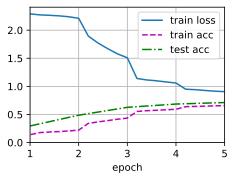

In [3]:
lr,num_epochs = 0.001,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)
d2l.train_epoch_ch8

In [4]:
#VGG
#AlexNet并没有提供简单的规则以指导后来的研究者如何设计新的网络
#通过重复使用简单的基础块来构建深度模型的思路。
#连续使用数个相同的填充为1、窗口形状为3×33×3的卷积层后接上一个步幅为2、
#窗口形状为2×22×2的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。(vgg_block)
#小卷积核可以在保证具有相同感受野的前提下代价更少(参数少),网络更深就可以学习更复杂的模式

In [29]:
import time
import torch
from torch import nn,optim

import sys
sys.path.append("..")
import d2l.torch as d2l
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def vgg_block(num_convs,in_channels,out_channels):
    blk = []
    for i in range(num_convs):
        if i==0:
            blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        else:
            blk.append(nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*blk)
#超参数conv_arch(每个vgg块里面卷积层个数和输入输出通道数)
conv_arch = ((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
#经过5个vgg_block,宽高会减半5次,变成224/32 = 7
fc_feature = 512 * 7 * 7
fc_hidden_units = 4096

#vgg11实现
def vgg(conv_arch,fc_features,fc_hidden_units=4096):
    net = nn.Sequential()
    #卷积层部分
    for i,(num_convs,in_channels,out_channels) in enumerate(conv_arch):
        net.add_module('vgg_block_'+str(i+1),vgg_block(num_convs,in_channels,out_channels))
    #全连接层
    net.add_module("fc",nn.Sequential(nn.Flatten(),
                                     nn.Linear(fc_features,fc_hidden_units),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(fc_hidden_units,fc_hidden_units),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(fc_hidden_units,10))
                  )
    return net

net = vgg(conv_arch,fc_feature,fc_hidden_units)
X = torch.rand(1,1,224,224)
## named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)                  
for name,blk in net.named_children():
    X = blk(X)
    print(name,'out_put shape:',X.shape)
#宽高减半到7,输入通道每次翻倍到512                  
                   

vgg_block_1 out_put shape: torch.Size([1, 64, 112, 112])
vgg_block_2 out_put shape: torch.Size([1, 128, 56, 56])
vgg_block_3 out_put shape: torch.Size([1, 256, 28, 28])
vgg_block_4 out_put shape: torch.Size([1, 512, 14, 14])
vgg_block_5 out_put shape: torch.Size([1, 512, 7, 7])
fc out_put shape: torch.Size([1, 10])


In [30]:
#出于测试目的,我们减少vgg通道数
ratio = 8
small_conv_arch = ((1,1,64//ratio),(1,64//ratio,128//ratio),(2,128//ratio,256//ratio),(2,256//ratio,512//ratio),(2,512//ratio,512//ratio))
net = vgg(small_conv_arch,fc_feature // ratio,fc_hidden_units // ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [44]:
batch_size = 64
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)

lr,num_epochs = 0.001,5
optimizer = torch.optim.Adam(net.parameters(),lr=lr)
def train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epoches):
    net = net.to(device)
    print("training on",device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epoches):
        train_l_sum,train_acc_sum,test_acc,n,batch_count,start = 0.0,0.0,0.0,0,0,time.time()
        for X,y in train_iter:#准备数据
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X) #forward
            l = loss(y_hat,y)#算Loss
            optimizer.zero_grad()#梯度清零
            l.backward()#反向传播
            optimizer.step()#更新权重
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item() #算对的数量
            n += y.shape[0]
            batch_count += 1
        test_acc += d2l.evaluate_accuracy_gpu(net,test_iter,device)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
# 本函数已保存在d2lzh_pytorch包中方便以后使用。该函数将被逐步改进。
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch5_new(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
# train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

In [34]:
#串联多个由卷积层和“全连接”层构成的小网络来构建一个深层网络。
#Input,卷机层（样本，通道，宽，高），全连接（样本，特征）
#NiN使用1×1卷积层来替代全连接层，从而使空间信息能够自然传递到后面的层中去。
#NiN块是NiN中的基础块。它由一个卷积层加两个充当全连接层的1×1卷积层串联而成。
import time
import torch
from torch import nn,optim
import sys

sys.path.append("..")

import d2l.torch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    blk = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),
                       nn.ReLU(),
                       nn.Conv2d(out_channels,out_channels,kernel_size = 1), #参数固定
                       nn.ReLU(),
                       nn.Conv2d(out_channels,out_channels,kernel_size=1),
                       nn.ReLU())
    return blk


In [37]:
#NiN去掉了AlexNet最后的3个全连接层，取而代之地，
#NiN使用了输出通道数等于标签类别数的NiN块，然后使用全局平均池化层对每个通道中所有元素求平均并直接用于分类。
import torch.nn.functional as F
class GlobalAvgPool2d(nn.Module):
    # 全局平均池化层，可将窗口设置成输入的宽高实现
    #全局平均池化则直接把整幅feature maps（它的个数等于类别个数）进行平均池化，然后输入到softmax层中得到对应的每个类别的得分。
    def __init__(self):
        super(GlobalAvgPool2d,self).__init__()
    def forward(self,x):
        return F.avg_pool2d(x,kernel_size=x.size()[2:])

net = nn.Sequential(
    nin_block(1,96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(96,256,kernel_size=5,stride=1,padding=2),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(256,384,kernel_size=3,stride=2,padding=1),
    nn.MaxPool2d(kernel_size=3,stride=2),
    nn.Dropout(0.5),
    #标签类别数是１０
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    GlobalAvgPool2d(),
    #四维转２维,形状是(批量大小,10)
    nn.Flatten()
    
)

In [39]:
x = torch.rand(1,1,224,224)
for name,blk in net.named_children():
    x = blk(x)
    print(name,'output shape:',x.shape)
#复习一下卷积层算输入输出(n_h-k_h+p_h+s_h)/s_h
#(224-11+0+4)/4-下取整



0 output shape: torch.Size([1, 96, 54, 54])
1 output shape: torch.Size([1, 96, 26, 26])
2 output shape: torch.Size([1, 256, 26, 26])
3 output shape: torch.Size([1, 256, 12, 12])
4 output shape: torch.Size([1, 384, 6, 6])
5 output shape: torch.Size([1, 384, 2, 2])
6 output shape: torch.Size([1, 384, 2, 2])
7 output shape: torch.Size([1, 10, 2, 2])
8 output shape: torch.Size([1, 10, 1, 1])
9 output shape: torch.Size([1, 10])


In [45]:
batch_size = 128
train_itera,test_iter = d2l.load_data_fashion_mnist(batch_size,resize=224)
lr,num_epochs = 0.002,5
optimizer = optim.Adam(net.parameters(),lr=lr)
train_ch5_new(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)

training on  cuda
epoch 1, loss 0.8040, train acc 0.680, test acc 0.667, time 27.3 sec
epoch 2, loss 0.8487, train acc 0.666, test acc 0.670, time 27.4 sec
epoch 3, loss 0.8283, train acc 0.672, test acc 0.675, time 27.7 sec
epoch 4, loss 0.8113, train acc 0.677, test acc 0.669, time 27.5 sec
epoch 5, loss 0.8033, train acc 0.679, test acc 0.662, time 27.6 sec
